### Imports and function declaration

In [3]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
from geopy import distance
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics
pd.set_option('display.max_columns', None)

# useful functions and classes

# This class stores the latitude and longitude of a sample, and indicates 
# if this location has the desired variable we are estimating
class Location:
    def __init__(self,latitude,longitude,hasv,ID,value,SHEET):
        self.ID = ID
        self.SHEET = SHEET
        self.latitude = latitude
        self.longitude = longitude
        self.hasv = hasv
        self.value = value
        
    def __str__(self):
        return str(self.ID)

# Calculates the distance between 2 samples in km
def getdist(S1,S2):
    # radius of earth in km
    coords_1 = (S1.latitude, S1.longitude)
    coords_2 = (S2.latitude, S2.longitude)
    dist = distance.distance(coords_1, coords_2).km
    return dist

# filters out data if a point is missing in one of the colunns
def filterblanks(columns,data,blank):
    # if blank is true, remove rows with blanks in these columns
    # if blank is false, remove rows with non blanks or non zeros in these columns
    for c in columns:
        if blank:
            data = data[data[c].notnull()].copy()
        else:
            data = data[data[c].isnull()].copy()
    return data

# PRE: all locations in the dataframe are
# unique
def DistanceMatrix(dataframe,variable):
    numunique = len(dataframe["LOCATCD"].unique())
    numlocations = dataframe.shape[0]
    try:
        assert(numunique == numlocations), f"{numunique} unique locations but {numlocations} number of locations"
    
    except AssertionError as msg:
        display(dataframe[dataframe["LOCATCD"].duplicated(keep=False)])
        print(msg)
        
    # the list of location objects
    locations = []
    # the list of indexes where the the row is located in the dataframe
    #indexes = []
    for index,row in dataframe.iterrows():
        # make a location object on this row
        if pd.isnull(row[variable]):
            hasv = False
        else:
            hasv = True
        locations.append(Location(row["LATITUDE"],row["LONGITUDE"],hasv,row["LOCATCD"],row[variable],row["SHEETBAR"]))
        #indexes.append(index)
        
    matrix = pd.DataFrame(0,index=locations,columns=locations)
    for ci,column in enumerate(locations):
        for ri,row in enumerate(locations):
            if ri>ci:
                # compute distance between column and row
                dist = getdist(row,column)
            elif ci>ri:
                dist = matrix.iloc[ci,ri]
            # put this distance in the dataframe
            else:
                continue
            matrix.iloc[ri,ci] = dist
    return matrix

def changeVar(DM,dataframe,variable):
    locations = DM.index
    # loop through each location
    for i,loc in enumerate(locations):
        SHEET = loc.SHEET
        row = dataframe.loc[dataframe["SHEETBAR"]==SHEET]
        #print(row)
        #print(row.shape)
        #print(row.loc[row.index[0],variable])
        #print(type(row[variable]))
        try:
            assert(row.shape[0]==1), "Multiple rows with same SHEETBAR"
        except AssertionError as msg:
            display(dataframe[dataframe["SHEETBAR"].duplicated(keep=False)])
            print(msg)
            
        # Pull value of desired variable
        val = row.loc[row.index[0],variable]
        if pd.isnull(val):
            locations[i].hasv = False
            locations[i].value = None
        else:
            locations[i].hasv = True
            locations[i].value = val
            
    DM.index = locations
    DM.columns = locations
        
def getclosest(numclosest,distancematrix,location):
    column = distancematrix.loc[:,location].copy()
    #print(type(distancematrix.index[0]))
    # Filter the locations that dont have the desired variable
    doesnthavev = []
    for i in range(len(column)):
        if not column.index[i].hasv:
            doesnthavev.append(column.index[i])
            
    # Get rid of locations that dont have the desired variable
    column.drop(doesnthavev,inplace = True)
    # Get rid of the location we are predicting for if it exists (it will only be in this list if we are testing)
    column.drop(location,inplace = True,errors="ignore")

    #print(type(column))
    column.sort_values(inplace = True)
    
    return column.iloc[0:numclosest]

# Key: Location Codes that need predicting
# Value: List of tuples (locatcd,distance,value)
def makeDict(DM,numclosest,testing):
    # Loop through each location without a value for variable
    closestDict = {}
    for loc in DM.columns:
        if not loc.hasv or testing:
            # Get the closest locations to loc THAT ISN'T LOC
            closest = getclosest(numclosest,DM,loc)
            # The list of tuples that contain location id, the distance, and the value for variable
            tuples = []
            for i,dist in enumerate(closest):
                SHEET = closest.index[i].SHEET
                val = closest.index[i].value
                tuples.append((SHEET,dist,val))
            closestDict[loc.SHEET] = tuples
    return closestDict

def predict(tuples,numclosest = 2):
    loc2 = tuples[0]
    loc3 = tuples[1]
    d12 = loc2[1]
    val2 = loc2[2]
    d13 = loc3[1]
    val3 = loc3[2]
    
    if d12 == d13:
        return 0.5*d12+0.5*d13
    elif d12 == 0:
        return val2
    elif d13 == 0:
        return val3
    
    else:
        c2 = d12/(d12+d13)
        c3 = d13/(d12+d13)
        
        predicted = c2*val2+c3*val3
    
        return predicted


# NEEDS WORK
def addpredictions(df,variables,numclosest):
    # make prediction and insert for each variable
    first = True
    for var in variables:
        if first:
            DM = DistanceMatrix(df,var)
        else:
            changeVar(DM,df,var)
            
        for loc in DM.columns:
            if not loc.hasv:
                # Get the closest locations to loc
                closest = getclosest(numclosest,DM,loc)
                # The list of tuples that contain location id, the distance, and the value for variable
                tuples = []
                for i,dist in enumerate(closest):
                    ID = closest.index[i].ID
                    val = closest.index[i].value
                    tuples.append((ID,dist,val))
                closestDict[loc.ID] = tuples

'''
data - the pandas dataframe that is ready to interpolate missing values
MUST HAVE "LATITUDE", "LONGITUDE","YEAR", "SEASON", "LOCATCD" columns

missing_vars - the list of column names (as strings) of the dataframe that we should attempt to fill in

numlocations - the number of locations used to predict the new value, default is 2 (currently the only option implemented)

RETURN - a dataframe with extra columns saying the predicted values of the missing_vars
'''
def linear_interpolate(data,missing_vars,numlocations = 2,testing = False,verbosity = 0):
    
    print("Building a new dataframe with predicted values")
    start_time = time.time()
    # Testing for duplicated locations if needed
    #s = qualdata_noprediction["LOCATCD"].duplicated(keep=False)
    # get the years and timecodes for this dataset
    # predictions can only be made if the point is in the same year and time code (what if we don't need to do this)
    years = data["YEAR"].unique()
    seasons = data["SEASON"].unique()
    pools = data["FLDNUM"].unique()
    data_prediction = pd.DataFrame()
    for pool in pools:
        for year in years:
            for season in seasons:
                if verbosity > 0:
                    print(f"Appending predicted data for {year}  {season}  FLDNUM {pool}")
                # curset is the current set of rows we are predicting for
                curset = data[(data["YEAR"]==year) & (data["SEASON"]==season) & (data["FLDNUM"]==pool)].copy()
                
                if verbosity > 1:
                    print("Size of this year and season:", curset.shape)
                
                # Boolean to indicate if variable in Distance matrix needs updating
                first = True
                for var in missing_vars:
                    newcolumn = "Predicted"+var
                    curset[newcolumn] = 0
                
                    #check to see if there are enough valid locations
                    # that can be used to predict
                    if not testing:
                        bad = bool((curset[var].notnull().sum()<numlocations))
                    else:
                        bad = bool((curset[var].notnull().sum()<numlocations+1))
                    
    
                    if(bad):
                        if verbosity > 2:
                            print("Less than "+str(numlocations)+" locations have "+var+" in this set, dropping rows without "+var)
                        curset = curset[curset[var].notnull()]
                        curset[newcolumn] = curset[var]
                        if verbosity > 2:
                            print("Current set is now ",curset.shape)
                    else:
                        if first:
                            if verbosity > 2:
                                print("Creating DM with ",var)
                            DM = DistanceMatrix(curset,var)
                            first = False
                        else:
                            if verbosity > 2:
                                print("Changing to ",var)
                            changeVar(DM,curset,var)
                            
                        # Returns a dictionary mapping each location code to a tuple with prediction information
                        Dict = makeDict(DM,numlocations,testing)
                        
                        #put in predicted variable
                        for index,row in curset.iterrows():
                            if pd.isnull(row[var]) or testing:
                                try:
                                    prediction = predict(Dict[row["SHEETBAR"]])
                                    #print(curset.loc[index,newcolumn],prediction)
                                    curset.loc[index,newcolumn] = prediction
                                except ZeroDivisionError:
                                    print("Couldn't predict for ", str(row["SHEETBAR"]))
                                    print(Dict[row["SHEETBAR"]])
                                    curset.loc[index,newcolumn] = None
                            else:
                                curset.loc[index,newcolumn] = row[var]
    
                data_prediction = data_prediction.append(curset,ignore_index=True)  
    
    if verbosity > 0:
        print("Final data set size is ",data_prediction.shape)
    print(f"Interpolating took {(time.time()-start_time)/60} minutes")
    return data_prediction

Below cells are for debugging purposes

In [63]:
testset = water_data[(water_data["YEAR"]==1998) & (water_data["SEASON"]=="FALL") & (water_data["FLDNUM"]==6)].copy()
DM = DistanceMatrix(testset,"TP")
print(testset.shape)
print(len(DM.index))

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
2525,46005136,10/17/1998,40.262942,-90.104416,6,3,9863008,NaN,NaN,19.0,10.3,56.0,683.0,0.08,44.3,1.40,73.53092,21.0,1998,10,FALL
2533,46005148,10/17/1998,40.262942,-90.104416,6,1,9863008,3.802,0.335,18.7,7.8,49.0,784.0,NaN,45.8,3.65,19.78580,24.0,1998,10,FALL


103 unique locations but 104 number of locations
(104, 21)
104


In [64]:
dups = [loc for loc in DM.columns if loc.ID==9863008]
dup1 = dups[0]
dup2 = dups[1]
print(len(dups))
print(dup1.value)
print(dup2.value)

2
nan
0.335


In [66]:
closest = getclosest(2,DM,dup1)
print(closest)

9863008    0.000000
9863189    0.872909
Name: 9863008, dtype: float64


In [67]:
Dict = makeDict(DM,2,False)

In [69]:
Dict[9863008]

[(9863008, 0.0, 0.335), (9863189, 0.8729090780987829, 0.224)]

Now change the variable

In [70]:
changeVar(DM,testset,"TN")
Dict = makeDict(DM,2,False)

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
2525,46005136,10/17/1998,40.262942,-90.104416,6,3,9863008,NaN,NaN,19.0,10.3,56.0,683.0,0.08,44.3,1.40,73.53092,21.0,1998,10,FALL
2533,46005148,10/17/1998,40.262942,-90.104416,6,1,9863008,3.802,0.335,18.7,7.8,49.0,784.0,NaN,45.8,3.65,19.78580,24.0,1998,10,FALL


Multiple rows with same LOCATCD


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
2525,46005136,10/17/1998,40.262942,-90.104416,6,3,9863008,NaN,NaN,19.0,10.3,56.0,683.0,0.08,44.3,1.40,73.53092,21.0,1998,10,FALL
2533,46005148,10/17/1998,40.262942,-90.104416,6,1,9863008,3.802,0.335,18.7,7.8,49.0,784.0,NaN,45.8,3.65,19.78580,24.0,1998,10,FALL


Multiple rows with same LOCATCD


In [72]:
Dict[9863008]

[(9863189, 0.8729090780987829, 1.075), (9863033, 0.9216334059295654, 1.219)]

In [44]:
testset[testset["LOCATCD"].duplicated(keep = False)]

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
2525,46005136,10/17/1998,40.262942,-90.104416,6,3,9863008,NaN,NaN,19.0,10.3,56.0,683.0,0.08,44.3,1.40,73.53092,21.0,1998,10,FALL
2533,46005148,10/17/1998,40.262942,-90.104416,6,1,9863008,3.802,0.335,18.7,7.8,49.0,784.0,NaN,45.8,3.65,19.78580,24.0,1998,10,FALL


In [136]:
changeVar(DM,testset,"TN")
TNDICT = makeDict(DM,2,False)
print("Before changeVar")
print(sum([loc.hasv for loc in DM.index]))
changeVar(DM,testset,"VEL")
VELDICT = makeDict(DM,2,False)
print("After changeVar")
print(sum([loc.hasv for loc in DM.index]))

Before changeVar
52
After changeVar
45


In [139]:
VELDICT[451105]

[(451124, 1.2086258464409638, 0.66), (451123, 1.2744045589426773, 0.65)]

In [140]:
TNDICT

{451105: [(451019, 0.7099711538589619, 2.878),
  (451039, 1.4310725299622225, 2.563)],
 451082: [(451019, 0.2821259029425052, 2.878),
  (451039, 1.0503174635613015, 2.563)],
 451080: [(451018, 0.19975937726756982, 2.44),
  (451019, 2.431252287849238, 2.878)],
 451081: [(451018, 0.28307790046318493, 2.44),
  (451020, 2.19788703155569, 2.547)],
 451083: [(451021, 1.8094015570576851, 2.811),
  (451022, 2.950225073127101, 2.718)],
 451084: [(451021, 2.2778777947179805, 2.811),
  (451022, 2.4146597975280195, 2.718)],
 451085: [(451022, 1.8427071632635694, 2.718),
  (451021, 3.2028136356516703, 2.811)],
 451086: [(451022, 0.7205883222350091, 2.718),
  (451021, 4.11922109584036, 2.811)],
 451087: [(451022, 0.44722549541740003, 2.718),
  (451021, 5.121995120526336, 2.811)],
 451088: [(451022, 0.7202102221326283, 2.718),
  (451021, 5.136846061605677, 2.811)],
 451089: [(451022, 1.1651146798722323, 2.718),
  (451023, 5.012125565782401, 2.462)],
 451091: [(451023, 2.9498085995562433, 2.462),
  (4

### Loading and Filtering data

In [4]:
water_path = r"..\..\LTRM data\water_data_qfneg.csv"
water_data = pd.read_csv(water_path, low_memory = False)
veg_path = r"..\..\LTRM data\ltrm_vegsrs_data_lat_long.csv"
veg_data = pd.read_csv(veg_path, low_memory = False)

continuous = ['TN','TP','TEMP','DO','TURB','COND','VEL','SS','WDP','CHLcal','SECCHI']
seasons = {3:"SPRING",4:"SPRING",5:"SPRING",6:"SUMMER",7:"SUMMER",8:"SUMMER",9:"FALL",10:"FALL",11:"FALL",12:"WINTER",1:"WINTER",2:"WINTER"}

print("Now adding a year column")
water_data["YEAR"] = pd.DatetimeIndex(water_data["DATE"]).year
print("Now adding a month column")
water_data["MONTH"] = pd.DatetimeIndex(water_data["DATE"]).month
print("Now adding a season column")
water_data["SEASON"] = water_data["MONTH"]
water_data = water_data.replace({"SEASON":seasons})

print("Veg data")
print(veg_data.columns)
print(veg_data.shape)

print("\n\n Water data")
print(water_data.columns)
print(water_data.shape)

print("Filtering by pool")
veg_data = veg_data[veg_data["FLDNUM"]==5].reset_index(drop=True)
water_data = water_data[water_data["FLDNUM"]==6].reset_index(drop=True)
print(veg_data.shape)
print(water_data.shape)

Now adding a year column
Now adding a month column
Now adding a season column
Veg data
Index(['BARCODE', 'ROWNUM', 'PAGENUM', 'FLDNUM', 'PROJCD', 'POOL', 'DATE',
       'LDRCODE', 'RCRDCODE', 'DETRITUS', 'SBSTRATE', 'SITECD', 'MSTRATUM',
       'ASTRATUM', 'RIVMILE', 'VEG_S', 'VEG_RF', 'VEG_E', 'VEG_A', 'VEG_NRF',
       'VEG_U', 'COV_NRF', 'COV_RF', 'COV_E', 'EAST1', 'NORTH1', 'ZONE',
       'ACCUR1', 'METHOD', 'EAST2', 'NORTH2', 'ACCUR2', 'ZONE_U', 'EAST_U',
       'NORTH_U', 'GRIDCODE', 'EAST_15', 'NORTH_15', 'HABITAT1', 'HABITAT2',
       'HABITAT3', 'HABITAT4', 'HABITAT5', 'HABITAT6', 'DEPTH1', 'DEPTH2',
       'DEPTH3', 'DEPTH4', 'DEPTH5', 'DEPTH6', 'DENSITY1', 'DENSITY2',
       'DENSITY3', 'DENSITY4', 'DENSITY5', 'DENSITY6', 'BATCHNUM', 'SPPCD',
       'VISUAL1', 'VISUAL2', 'VISUAL3', 'VISUAL4', 'VISUAL5', 'VISUAL6',
       'RAKE1', 'RAKE2', 'RAKE3', 'RAKE4', 'RAKE5', 'RAKE6', 'ADDSPP',
       'COVSPP', 'QECODE', 'VOUCHER', 'LATITUDE', 'LONGITUDE'],
      dtype='object')
(12506

In [39]:
water_data.head()

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
0,45000007,09/15/1993,37.32989,-89.47505,5,2,9353150,NaN,NaN,20.7,7.3,69.0,463.0,NaN,125.0,16.1,8.45574,16.0,1993,9,FALL
1,45000008,09/15/1993,37.32201,-89.45285,5,2,9353152,NaN,NaN,20.6,7.4,66.0,465.0,NaN,121.8,11.5,9.67430,16.0,1993,9,FALL
2,45000009,09/15/1993,37.37297,-89.40981,5,2,9353048,3.376,0.339,21.0,7.3,64.0,480.0,NaN,105.3,10.5,9.06502,14.0,1993,9,FALL
3,45000010,09/15/1993,37.32701,-89.43908,5,2,9353151,NaN,NaN,20.7,7.3,66.0,470.0,NaN,127.2,9.9,9.50022,16.0,1993,9,FALL
4,45000011,09/15/1993,37.32995,-89.47730,5,2,9353149,NaN,NaN,20.6,7.3,65.0,463.0,NaN,117.8,8.3,8.80390,16.0,1993,9,FALL


Checking negative values

In [4]:
(water_data[continuous] < 0).sum()

TN        0
TP        0
TEMP      0
DO        0
TURB      0
COND      0
VEL       0
SS        0
WDP       0
CHLcal    0
SECCHI    0
dtype: int64

Checking for weird location codes

In [155]:
num_weird = 0
for index,row in water_data.iterrows():
    if not str(row["LOCATCD"]).isnumeric():
        num_weird += 1
        #print(row["LOCATCD"],row["YEAR"])
print(num_weird)

0


Insanity check for time seasons

In [156]:
water_data["SEASON"].unique()

array(['FALL', 'WINTER', 'SPRING', 'SUMMER'], dtype=object)

#### Checking stratum data size

In [157]:
water_data["STRATUM"].unique()

array([2, 1], dtype=int64)

In [158]:
water_data[water_data["STRATUM"].isna()]

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON


In [160]:
sum(water_data["STRATUM"] == 1)

7640

In [161]:
sum(water_data["STRATUM"]==2)

6560

#### Taking a look at our variables

In [5]:
water_data[continuous].describe()

,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI
count,5653.000000,5487.000000,14096.000000,14063.000000,13972.000000,14087.000000,4413.000000,13835.000000,13719.000000,14055.000000,13255.000000
mean,2.942685,0.251580,16.521283,8.995762,104.876038,530.615816,0.750376,146.823285,7.069427,17.775536,23.878084
std,1.231648,0.118471,9.440878,2.716562,107.388126,83.961121,0.459998,144.560339,4.099851,12.343985,13.076579
min,0.024000,0.002000,0.000000,0.000000,3.000000,168.000000,0.000000,0.020000,0.200000,0.018300,1.000000
25%,2.251000,0.181000,12.700000,7.000000,40.000000,468.000000,0.390000,56.760000,4.000000,9.314200,14.000000
50%,2.915000,0.230000,16.900000,8.300000,75.000000,531.000000,0.750000,104.400000,6.500000,14.479140,21.000000
75%,3.528000,0.298000,26.000000,10.300000,125.000000,588.000000,1.080000,183.085000,9.600000,22.842685,30.000000
max,32.965000,3.500000,34.000000,25.000000,1330.000000,970.000000,2.270000,1439.600000,40.200000,151.036340,250.000000


#### Boxplots and histograms

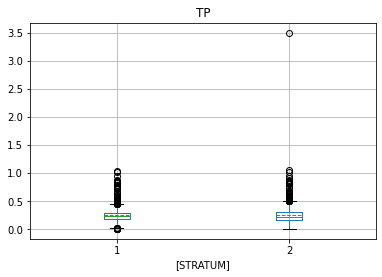

In [63]:
var = "TP"
water_data[[var,'STRATUM']].boxplot(by='STRATUM', meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True,return_type = 'axes')
plt.suptitle('') # that's what you're after
plt.show()

Text(0.5, 0.98, 'TP')

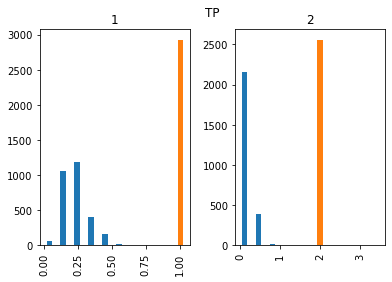

In [64]:
water_data[[var,'STRATUM']].hist(by='STRATUM')
plt.suptitle(var) # that's what you're after

#### Missing data

In [6]:
water_data[continuous].isnull().sum()

TN        8547
TP        8713
TEMP       104
DO         137
TURB       228
COND       113
VEL       9787
SS         365
WDP        481
CHLcal     145
SECCHI     945
dtype: int64

How much data is TDA ready?

In [164]:
water_filtered = water_data.dropna(axis=0, how='any', thresh=None, subset=continuous, inplace=False)

In [165]:
water_filtered.shape

(1512, 21)

Text(0.5, 1.0, 'Number of Data Points by year')

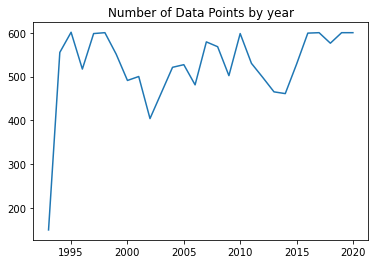

In [69]:
water_data["YEAR"].value_counts().sort_index().plot()
plt.title("Number of Data Points by year")

#### Interpolating missing data (by year, by timecode)

In [14]:
continuous = ['TN','TP','TEMP','DO','TURB','COND','VEL','SS','WDP','CHLcal','SECCHI']
missing_vars = ["TN","TP","VEL"]
water_interpolated = linear_interpolate(water_data,continuous,verbosity=2)

TypeError: linear_interpolate() got an unexpected keyword argument 'verbosity'

Look at the interpolated dataset

In [169]:
water_interpolated[["PredictedTP","TP","PredictedTN","TN","PredictedVEL","VEL"]].head(20)

,PredictedTP,TP,PredictedTN,TN,PredictedVEL,VEL
0,0.129000,0.129,2.514000,2.514,0.150613,NaN
1,0.095000,0.095,1.399000,1.399,0.343573,NaN
2,0.084000,0.084,1.273000,1.273,0.010000,0.01
3,0.130000,0.130,1.172000,1.172,0.610000,0.61
4,0.103828,NaN,1.229465,NaN,0.040000,0.04
5,0.126000,0.126,1.332000,1.332,0.310000,0.31
6,0.093000,0.093,1.184000,1.184,0.000000,0.00
7,0.082308,NaN,1.292848,NaN,0.020000,0.02
8,0.085000,0.085,1.302000,1.302,0.100000,0.10
9,0.080000,0.080,1.285000,1.285,0.060000,0.06


In [170]:
water_interpolated.to_csv("Open_river_interpolatedTN_TP_VEL.csv")

In [97]:
pickle.dump(water_interpolated, open( "open_river_interpolated(TN,TP).p", "wb" ) )

Now see how many rows we gained after interpolation

In [148]:
used = ['PredictedTN','PredictedTP','TEMP','DO','TURB','COND','SS','WDP','CHLcal','SECCHI','PredictedVEL']

water_filtered_interpolated = water_interpolated.dropna(axis=0, how='any', thresh=None, subset=used, inplace=False)
water_filtered_interpolated.shape

(11295, 24)

#### Checking how good we did with prediction on each variable, first we need to filter the data based off values we already have

In [171]:
water_testTN = water_data[water_data["TN"].notna()]
water_testTP = water_data[water_data["TP"].notna()]
water_testVEL = water_data[water_data["VEL"].notna()]

In [172]:
water_testTN[water_testTN["LOCATCD"].duplicated(keep = False)]

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
412,45000576,07/26/1994,37.422368,-89.434562,5,1,9452016,2.806,0.300,16.43302,6.1,97.0,550.0,NaN,165.1,4.3,16.43302,14.0,1994,7,SUMMER
511,45000678,08/02/1994,37.422368,-89.434562,5,1,9452016,3.342,0.138,21.20282,7.0,52.0,579.0,NaN,74.7,5.9,21.20282,25.0,1994,8,SUMMER
656,45000889,10/21/1994,37.605074,-89.518704,5,2,9453048,1.319,0.067,107.51494,13.7,31.0,584.0,NaN,32.5,NaN,107.51494,37.0,1994,10,FALL
666,45000899,10/24/1994,37.605074,-89.518704,5,2,9453048,2.451,0.067,24.97093,10.1,42.0,561.0,NaN,48.5,NaN,24.97093,35.0,1994,10,FALL
746,45001047,02/01/1995,37.302165,-89.512431,5,1,9554030,3.168,0.193,10.22010,13.4,73.0,450.0,NaN,99.8,NaN,10.22010,23.0,1995,2,WINTER
838,45001147,02/07/1995,37.302165,-89.512431,5,1,9554030,2.691,0.178,7.48810,13.0,90.0,418.0,NaN,183.1,NaN,7.48810,23.0,1995,2,WINTER
3705,45007660,04/26/2000,37.379887,-89.415126,5,2,51039,1.976,0.143,34.19622,9.5,20.0,575.0,0.03,22.9,4.1,34.19622,43.0,2000,4,SPRING
4169,45008797,04/23/2001,37.379887,-89.415126,5,2,51039,4.233,0.451,8.36941,8.4,252.0,422.0,NaN,328.4,4.3,8.36941,16.0,2001,4,SPRING


In [173]:
water_testTP[water_testTP["LOCATCD"].duplicated(keep = False)]

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON
412,45000576,07/26/1994,37.422368,-89.434562,5,1,9452016,2.806,0.300,16.43302,6.1,97.0,550.0,NaN,165.1,4.3,16.43302,14.0,1994,7,SUMMER
511,45000678,08/02/1994,37.422368,-89.434562,5,1,9452016,3.342,0.138,21.20282,7.0,52.0,579.0,NaN,74.7,5.9,21.20282,25.0,1994,8,SUMMER
656,45000889,10/21/1994,37.605074,-89.518704,5,2,9453048,1.319,0.067,107.51494,13.7,31.0,584.0,NaN,32.5,NaN,107.51494,37.0,1994,10,FALL
666,45000899,10/24/1994,37.605074,-89.518704,5,2,9453048,2.451,0.067,24.97093,10.1,42.0,561.0,NaN,48.5,NaN,24.97093,35.0,1994,10,FALL
746,45001047,02/01/1995,37.302165,-89.512431,5,1,9554030,3.168,0.193,10.22010,13.4,73.0,450.0,NaN,99.8,NaN,10.22010,23.0,1995,2,WINTER
838,45001147,02/07/1995,37.302165,-89.512431,5,1,9554030,2.691,0.178,7.48810,13.0,90.0,418.0,NaN,183.1,NaN,7.48810,23.0,1995,2,WINTER
3705,45007660,04/26/2000,37.379887,-89.415126,5,2,51039,1.976,0.143,34.19622,9.5,20.0,575.0,0.03,22.9,4.1,34.19622,43.0,2000,4,SPRING
4169,45008797,04/23/2001,37.379887,-89.415126,5,2,51039,4.233,0.451,8.36941,8.4,252.0,422.0,NaN,328.4,4.3,8.36941,16.0,2001,4,SPRING


In [174]:
water_testVEL[water_testVEL["LOCATCD"].duplicated(keep = False)]

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON


Looking at accuracy of TN

In [175]:
missing_vars = ["TN"]
water_test_interpolatedTN = linear_interpolate(water_testTN,missing_vars,testing=True)

Building a new dataframe with predicted values
Appending predicted data for  1993    FALL
Size of this year and season: (80, 21)
Creating DM with  TN
Appending predicted data for  1993    WINTER
Size of this year and season: (0, 21)
Less than 2 locations have TN in this set, dropping rows without TN
Current set is now  (0, 22)
Appending predicted data for  1993    SPRING
Size of this year and season: (0, 21)
Less than 2 locations have TN in this set, dropping rows without TN
Current set is now  (0, 22)
Appending predicted data for  1993    SUMMER
Size of this year and season: (0, 21)
Less than 2 locations have TN in this set, dropping rows without TN
Current set is now  (0, 22)
Appending predicted data for  1994    FALL
Size of this year and season: (78, 21)
Creating DM with  TN


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON,PredictedTN
656,45000889,10/21/1994,37.605074,-89.518704,5,2,9453048,1.319,0.067,107.51494,13.7,31.0,584.0,NaN,32.5,NaN,107.51494,37.0,1994,10,FALL,0
666,45000899,10/24/1994,37.605074,-89.518704,5,2,9453048,2.451,0.067,24.97093,10.1,42.0,561.0,NaN,48.5,NaN,24.97093,35.0,1994,10,FALL,0


77 unique locations but 78 number of locations
Appending predicted data for  1994    WINTER
Size of this year and season: (64, 21)
Creating DM with  TN
Appending predicted data for  1994    SPRING
Size of this year and season: (71, 21)
Creating DM with  TN
Appending predicted data for  1994    SUMMER
Size of this year and season: (81, 21)
Creating DM with  TN


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON,PredictedTN
412,45000576,07/26/1994,37.422368,-89.434562,5,1,9452016,2.806,0.300,16.43302,6.1,97.0,550.0,NaN,165.1,4.3,16.43302,14.0,1994,7,SUMMER,0
511,45000678,08/02/1994,37.422368,-89.434562,5,1,9452016,3.342,0.138,21.20282,7.0,52.0,579.0,NaN,74.7,5.9,21.20282,25.0,1994,8,SUMMER,0


80 unique locations but 81 number of locations
Appending predicted data for  1995    FALL
Size of this year and season: (84, 21)
Creating DM with  TN
Appending predicted data for  1995    WINTER
Size of this year and season: (80, 21)
Creating DM with  TN


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON,PredictedTN
746,45001047,02/01/1995,37.302165,-89.512431,5,1,9554030,3.168,0.193,10.2201,13.4,73.0,450.0,NaN,99.8,NaN,10.2201,23.0,1995,2,WINTER,0
838,45001147,02/07/1995,37.302165,-89.512431,5,1,9554030,2.691,0.178,7.4881,13.0,90.0,418.0,NaN,183.1,NaN,7.4881,23.0,1995,2,WINTER,0


79 unique locations but 80 number of locations
Appending predicted data for  1995    SPRING
Size of this year and season: (81, 21)
Creating DM with  TN
Appending predicted data for  1995    SUMMER
Size of this year and season: (84, 21)
Creating DM with  TN
Appending predicted data for  1996    FALL
Size of this year and season: (83, 21)
Creating DM with  TN
Appending predicted data for  1996    WINTER
Size of this year and season: (82, 21)
Creating DM with  TN
Appending predicted data for  1996    SPRING
Size of this year and season: (46, 21)
Creating DM with  TN
Appending predicted data for  1996    SUMMER
Size of this year and season: (86, 21)
Creating DM with  TN
Appending predicted data for  1997    FALL
Size of this year and season: (87, 21)
Creating DM with  TN
Appending predicted data for  1997    WINTER
Size of this year and season: (85, 21)
Creating DM with  TN
Appending predicted data for  1997    SPRING
Size of this year and season: (89, 21)
Creating DM with  TN
Appending pr

In [185]:
TN_MAE = sklearn.metrics.mean_absolute_error(water_test_interpolatedTN["TN"],water_test_interpolatedTN["PredictedTN"])
TN_RMSE = sklearn.metrics.mean_squared_error(water_test_interpolatedTN["TN"],water_test_interpolatedTN["PredictedTN"],squared=False)
print(f"The MAE for TN is {TN_MAE:8f}")
print(f"The RMSE for TN is {TN_RMSE:8f}")
water_test_interpolatedTN["TN error"] = round(abs(water_test_interpolatedTN["TN"] - water_test_interpolatedTN["PredictedTN"]),6)
water_test_interpolatedTN["TN squared error"] = round((water_test_interpolatedTN["TN"] - water_test_interpolatedTN["PredictedTN"])**2,6)
print(water_test_interpolatedTN["TN error"].describe())
print(water_test_interpolatedTN["TN squared error"].describe())

The MAE for TN is 0.268124
The RMSE for TN is 0.927333
count    5653.000000
mean        0.268124
std         0.887804
min         0.000000
25%         0.048168
50%         0.107408
75%         0.233224
max        29.510739
Name: TN error, dtype: float64
count    5653.000000
mean        0.859947
std        15.576618
min         0.000000
25%         0.002320
50%         0.011537
75%         0.054394
max       870.883725
Name: TN squared error, dtype: float64


Looking at accuracy of TP

In [186]:
missing_vars = ["TP"]
water_test_interpolatedTP = linear_interpolate(water_testTP,missing_vars,testing=True)

Building a new dataframe with predicted values
Appending predicted data for  1993    FALL
Size of this year and season: (80, 21)
Creating DM with  TP
Appending predicted data for  1993    WINTER
Size of this year and season: (0, 21)
Less than 2 locations have TP in this set, dropping rows without TP
Current set is now  (0, 22)
Appending predicted data for  1993    SPRING
Size of this year and season: (0, 21)
Less than 2 locations have TP in this set, dropping rows without TP
Current set is now  (0, 22)
Appending predicted data for  1993    SUMMER
Size of this year and season: (0, 21)
Less than 2 locations have TP in this set, dropping rows without TP
Current set is now  (0, 22)
Appending predicted data for  1994    FALL
Size of this year and season: (78, 21)
Creating DM with  TP


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON,PredictedTP
656,45000889,10/21/1994,37.605074,-89.518704,5,2,9453048,1.319,0.067,107.51494,13.7,31.0,584.0,NaN,32.5,NaN,107.51494,37.0,1994,10,FALL,0
666,45000899,10/24/1994,37.605074,-89.518704,5,2,9453048,2.451,0.067,24.97093,10.1,42.0,561.0,NaN,48.5,NaN,24.97093,35.0,1994,10,FALL,0


77 unique locations but 78 number of locations
Appending predicted data for  1994    WINTER
Size of this year and season: (64, 21)
Creating DM with  TP
Appending predicted data for  1994    SPRING
Size of this year and season: (71, 21)
Creating DM with  TP
Appending predicted data for  1994    SUMMER
Size of this year and season: (81, 21)
Creating DM with  TP


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON,PredictedTP
412,45000576,07/26/1994,37.422368,-89.434562,5,1,9452016,2.806,0.300,16.43302,6.1,97.0,550.0,NaN,165.1,4.3,16.43302,14.0,1994,7,SUMMER,0
511,45000678,08/02/1994,37.422368,-89.434562,5,1,9452016,3.342,0.138,21.20282,7.0,52.0,579.0,NaN,74.7,5.9,21.20282,25.0,1994,8,SUMMER,0


80 unique locations but 81 number of locations
Appending predicted data for  1995    FALL
Size of this year and season: (84, 21)
Creating DM with  TP
Appending predicted data for  1995    WINTER
Size of this year and season: (80, 21)
Creating DM with  TP


,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,MONTH,SEASON,PredictedTP
746,45001047,02/01/1995,37.302165,-89.512431,5,1,9554030,3.168,0.193,10.2201,13.4,73.0,450.0,NaN,99.8,NaN,10.2201,23.0,1995,2,WINTER,0
838,45001147,02/07/1995,37.302165,-89.512431,5,1,9554030,2.691,0.178,7.4881,13.0,90.0,418.0,NaN,183.1,NaN,7.4881,23.0,1995,2,WINTER,0


79 unique locations but 80 number of locations
Appending predicted data for  1995    SPRING
Size of this year and season: (81, 21)
Creating DM with  TP
Appending predicted data for  1995    SUMMER
Size of this year and season: (84, 21)
Creating DM with  TP
Appending predicted data for  1996    FALL
Size of this year and season: (0, 21)
Less than 2 locations have TP in this set, dropping rows without TP
Current set is now  (0, 22)
Appending predicted data for  1996    WINTER
Size of this year and season: (82, 21)
Creating DM with  TP
Appending predicted data for  1996    SPRING
Size of this year and season: (46, 21)
Creating DM with  TP
Appending predicted data for  1996    SUMMER
Size of this year and season: (0, 21)
Less than 2 locations have TP in this set, dropping rows without TP
Current set is now  (0, 22)
Appending predicted data for  1997    FALL
Size of this year and season: (87, 21)
Creating DM with  TP
Appending predicted data for  1997    WINTER
Size of this year and season:

In [187]:
TP_MAE = sklearn.metrics.mean_absolute_error(water_test_interpolatedTP["TP"],water_test_interpolatedTP["PredictedTP"])
TP_RMSE = sklearn.metrics.mean_squared_error(water_test_interpolatedTP["TP"],water_test_interpolatedTP["PredictedTP"],squared=False)
print(f"The MAE for TP is {TP_MAE:8f}")
print(f"The RMSE for TP is {TP_RMSE:8f}")
water_test_interpolatedTP["TP error"] = round(abs(water_test_interpolatedTP["TP"] - water_test_interpolatedTP["PredictedTP"]),6)
water_test_interpolatedTP["TP squared error"] = round((water_test_interpolatedTP["TP"] - water_test_interpolatedTP["PredictedTP"])**2,6)
print(water_test_interpolatedTP["TP error"].describe())
print(water_test_interpolatedTP["TP squared error"].describe())

The MAE for TP is 0.034336
The RMSE for TP is 0.073393
count    5487.000000
mean        0.034336
std         0.064872
min         0.000000
25%         0.007334
50%         0.017890
75%         0.040500
max         3.096893
Name: TP error, dtype: float64
count    5487.000000
mean        0.005387
std         0.130943
min         0.000000
25%         0.000054
50%         0.000320
75%         0.001640
max         9.590747
Name: TP squared error, dtype: float64


Looking at accuracy of VEL

In [188]:
missing_vars = ["VEL"]
water_test_interpolatedVEL = linear_interpolate(water_testVEL,missing_vars,testing=True)

Building a new dataframe with predicted values
Appending predicted data for  1995    WINTER
Size of this year and season: (1, 21)
Less than 2 locations have VEL in this set, dropping rows without VEL
Current set is now  (1, 22)
Appending predicted data for  1995    SUMMER
Size of this year and season: (71, 21)
Creating DM with  VEL
Appending predicted data for  1995    FALL
Size of this year and season: (74, 21)
Creating DM with  VEL
Appending predicted data for  1995    SPRING
Size of this year and season: (0, 21)
Less than 2 locations have VEL in this set, dropping rows without VEL
Current set is now  (0, 22)
Appending predicted data for  1996    WINTER
Size of this year and season: (75, 21)
Creating DM with  VEL
Appending predicted data for  1996    SUMMER
Size of this year and season: (55, 21)
Creating DM with  VEL
Appending predicted data for  1996    FALL
Size of this year and season: (40, 21)
Creating DM with  VEL
Appending predicted data for  1996    SPRING
Size of this year an

In [190]:
VEL_MAE = sklearn.metrics.mean_absolute_error(water_test_interpolatedVEL["VEL"],water_test_interpolatedVEL["PredictedVEL"])
VEL_RMSE = sklearn.metrics.mean_squared_error(water_test_interpolatedVEL["VEL"],water_test_interpolatedVEL["PredictedVEL"],squared=False)
print(f"The MAE for VEL is {VEL_MAE:8f}")
print(f"The RMSE for VEL is {VEL_RMSE:8f}")
water_test_interpolatedVEL["VEL error"] = round(abs(water_test_interpolatedVEL["VEL"] - water_test_interpolatedVEL["PredictedVEL"]),6)
water_test_interpolatedVEL["VEL squared error"] = round((water_test_interpolatedVEL["VEL"] - water_test_interpolatedVEL["PredictedVEL"])**2,6)
print(water_test_interpolatedVEL["VEL error"].describe())
print(water_test_interpolatedVEL["VEL squared error"].describe())

The MAE for VEL is 0.208643
The RMSE for VEL is 0.305385
count    4413.000000
mean        0.208643
std         0.223023
min         0.000000
25%         0.051074
50%         0.138000
75%         0.290965
max         1.687500
Name: VEL error, dtype: float64
count    4413.000000
mean        0.093260
std         0.210820
min         0.000000
25%         0.002609
50%         0.019044
75%         0.084660
max         2.847657
Name: VEL squared error, dtype: float64


### Multivariate Regression Attempt on Open River

Filter for non missing data

In [208]:
cols = ['TP','TN','CHLcal','SS','VEL','DO','COND','WDP','TURB','TEMP','SECCHI']
print("Filtering out all rows with missing data")
qualdata = water_data.dropna(axis=0, how='any', thresh=None, subset=cols, inplace=False).copy()
print(qualdata.shape)
print("Filtering out colums that we dont need")
qualdata.drop(qualdata.columns.difference(cols), 1, inplace=True)
print(qualdata.shape)

Filtering out all rows with missing data
(1512, 21)
Filtering out colums that we dont need
(1512, 11)


In [210]:
# Model Hyperparameter: Set the degree of the polynomial to fit
d = 5

predictors = ['CHLcal','SS','VEL','DO','COND','WDP','TURB','TEMP','SECCHI']

X = np.array(qualdata[predictors])
TP = np.array(qualdata['TP'])
TN = np.array(qualdata['TN'])

# Good idea to standardize predictor attributes - assumes each variable has a decently normal distribution
scaler = RobustScaler().fit(X)
X_standard = scaler.transform(X)


# The PolynomialFeatures class in sklearn.preprocessing can be used to transform a data matrix by
# adding higher-order and interaction terms for the existing features. It also adds a "zeroth"
# column consisting of all 1's that corresponds to the weight w_0 in a regression model.
poly = PolynomialFeatures(d)

# We "fit" the poly object to our data matrix to allow it to identify the structure of the data
# (notably the number of attributes, or columns, in the data matrix).
poly.fit(X_standard)
#poly.fit(X)


# Now we use poly.transform to add any higher-order terms to the data matrix.
# This also adds a zeroth attribute which is set to all 1's.
augmented_X = poly.transform(X_standard)
#augmented_X = poly.transform(X)


# Next we create a linear regression object (named lm for "linear model").
# Because our augmented data matrix includes an all 1's column, we don't
# need to fit the intercept (w_0) here.
TP_lm = LinearRegression(fit_intercept=False)
TN_lm = LinearRegression(fit_intercept=False)


# Split data into train and test for each
TPX_train, TPX_test, TPy_train, TPy_test = train_test_split(augmented_X, TP, train_size=0.7)
TNX_train, TNX_test, TNy_train, TNy_test = train_test_split(augmented_X, TN, train_size=0.7)

# Fit models using training data
TP_lm.fit(TPX_train, TPy_train)
TN_lm.fit(TNX_train, TNy_train)

# After fitting the regression model, we can estimate the error
# Get training errors
TP_train_err = np.mean((TPy_train - TP_lm.predict(TPX_train)) ** 2)
TN_train_err = np.mean((TNy_train - TN_lm.predict(TNX_train)) ** 2)

# Get test errors
TP_test_err = np.mean((TPy_test - TP_lm.predict(TPX_test)) ** 2)
TN_test_err = np.mean((TNy_test - TN_lm.predict(TNX_test)) ** 2)

# Report
print("TP training set mean squared error: {:.6f}".format(TP_train_err)," on average off {:.6f}".format(np.sqrt(TP_train_err)))
print("TN training set mean squared error: {:.6f}".format(TN_train_err)," on average off {:.6f}".format(np.sqrt(TN_train_err)),"\n")
print("TP test set mean squared error: {:.6f}".format(TP_test_err)," on average off {:.6f}".format(np.sqrt(TP_test_err)))
print("TN test set mean squared error: {:.6f}".format(TN_test_err)," on average off {:.6f}".format(np.sqrt(TN_test_err)),"\n")

TP training set mean squared error: 0.000000  on average off 0.000000
TN training set mean squared error: 0.000000  on average off 0.000000 

TP test set mean squared error: 176.581080  on average off 13.288381
TN test set mean squared error: 12533.769979  on average off 111.954321 

